## Supermesh projection by hand

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from adapt_utils.plotting import *

In [4]:
from firedrake import *
import firedrake.supermeshing as supermesh

Supermesh projection is given by solving

$$M_T q_T = M_{ST} q_S$$

for a target vector $q_T$, where $q_S$ is the source vector, $M_T$ is the mass matrix for the target space and $M_{ST}$ is the mixed mass matrix for the source and target spaces.

In [5]:
def supermesh_project(src, tgt, check_mass=False, mixed_mass_matrix=None, solver=None):
    source_space = src.function_space()
    target_space = tgt.function_space()
    
    # Step 1: Form the RHS:
    #    rhs := Mst * src
    Mst = mixed_mass_matrix or supermesh.assemble_mixed_mass_matrix(source_space, target_space)
    with tgt.dat.vec_ro as vt:
        rhs = vt.copy()
    with src.dat.vec_ro as vs:
        Mst.mult(vs, rhs)
    
    # Step 2: Solve the linear system for the target:
    #    Mt * tgt = rhs
    ksp = solver or PETSc.KSP().create()
    if solver is None:
        Mt = assemble(inner(TrialFunction(target_space), TestFunction(target_space))*dx).M.handle
        ksp.setOperators(Mt)
        ksp.setFromOptions()
    with tgt.dat.vec as vt:
        ksp.solve(rhs, vt)
    
    if check_mass:
        assert np.allclose(assemble(src*dx), assemble(tgt*dx))

_In practice it would probably be good to keep the mixed mass matrix and solver object to reuse_ $\rightarrow$ see later.

Consider a non-trivial example

In [6]:
Hs = UnitSquareMesh(20, 25, diagonal='left')
Ht = UnitSquareMesh(20, 20, diagonal='right')
Vs = FunctionSpace(Hs, "CG", 1)
Vt = FunctionSpace(Ht, "CG", 1)
xs, ys = SpatialCoordinate(Hs)

In [7]:
s_init = Function(Vs, name="Initial source")
s_init.interpolate(sin(pi*xs)*sin(pi*ys))
s = Function(Vs, name="Source").assign(s_init)
t = Function(Vt, name="Target")

In [8]:
supermesh_project(s, t)

Source mass = 0.4039
Target mass = 0.4039


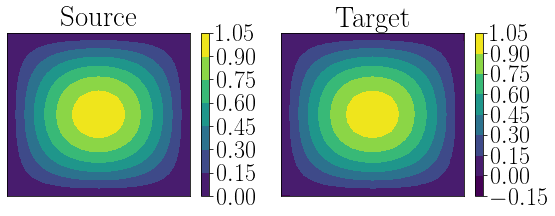

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
for i, f in enumerate((s, t)):
    ax = axes[i]
    fig.colorbar(tricontourf(f, axes=axes[i], vmin=0.0, vmax=1.0), ax=ax)
    ax.set_title(f.dat.name)
    print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

If we project back to the source mesh then we can compare the fields directly

In [10]:
supermesh_project(t, s)

Initial source mass = 0.4039
Projection mass = 0.4039
Relative L2 error = 0.02%
Relative mass error = 0.00%


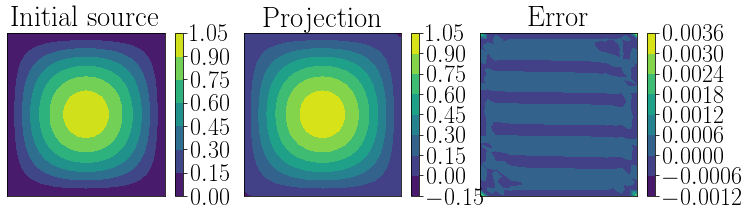

In [11]:
s.dat.name = 'Projection'
err = Function(s_init, name="Error")
err -= s

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, f in enumerate((s_init, s, err)):
    ax = axes[i]
    fig.colorbar(tricontourf(f, axes=ax), ax=ax)
    ax.set_title(f.dat.name)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    if f != err:
        print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
print("Relative L2 error = {:.2f}%".format(100*errornorm(s, s_init)/norm(s_init)))
print("Relative mass error = {:.2f}%".format(100*abs(assemble(s*dx)-assemble(s_init*dx))/assemble(abs(s_init)*dx)))

We see that, while the propagated profile resembles the seed profile, it has a significantly lower mass.
Consider repeatedly applying these operations:

In [12]:
N = 10

In [13]:
%%timeit
s.assign(s_init)
for i in range(N):
    supermesh_project(s, t)
    supermesh_project(t, s)

3.88 s ± 85.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Initial source mass = 0.4039
...after 10 projections mass = 0.4039


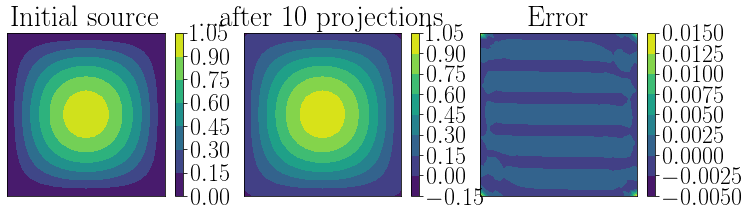

In [14]:
s.dat.name = "...after {:d} projections".format(N)
err = Function(s_init, name="Error")
err -= s

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, f in enumerate((s_init, s, err)):
    ax = axes[i]
    fig.colorbar(tricontourf(f, axes=ax), ax=ax)
    ax.set_title(f.dat.name)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    if f != err:
        print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))

Now try with assembled matrices

In [15]:
M_st = supermesh.assemble_mixed_mass_matrix(Vs, Vt)
M_ts = supermesh.assemble_mixed_mass_matrix(Vt, Vs)
M_s = assemble(inner(TrialFunction(Vs), TestFunction(Vs))*dx).M.handle
M_t = assemble(inner(TrialFunction(Vt), TestFunction(Vt))*dx).M.handle

In [16]:
solver_s = PETSc.KSP().create()
solver_s.setOperators(M_s)
solver_s.setFromOptions()
solver_t = PETSc.KSP().create()
solver_t.setOperators(M_t)
solver_t.setFromOptions()

In [17]:
%%timeit
s.assign(s_init)
N = 10
for i in range(N):
    supermesh_project(s, t, mixed_mass_matrix=M_st, solver=solver_t)
    supermesh_project(t, s, mixed_mass_matrix=M_ts, solver=solver_s)

2.78 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It's much faster! Let's always do this from now on.

Note that the mixed mass matrix $M_{ST}$ is identical to the transposed mixed mass matrix $M_{TS}^T$. This follows from their definition:

$$(M_{ST})_{ij}:=\int_\Omega\phi_S^i\phi_T^j\;\mathrm dx,$$

$$(M_{TS})_{ij}:=\int_\Omega\phi_T^i\phi_S^j\;\mathrm dx,$$

where $\phi_S$ and $\phi_T$ are test functions for the source and target spaces, respectively.

Hence we can just pass the following...

In [18]:
M_ts = M_st.copy()
M_ts.transpose();

In [19]:
N = 100
mass_init = assemble(s_init*dx)
l2_error = []
mass_error = []
s.assign(s_init)
for i in range(N):
    supermesh_project(s, t, mixed_mass_matrix=M_st, solver=solver_t)
    supermesh_project(t, s, mixed_mass_matrix=M_ts, solver=solver_s)
    l2_error.append(errornorm(s, s_init)/norm(s_init))
    mass_error.append(abs(assemble(s*dx) - mass_init)/abs(mass_init))

s.dat.name = "...after {:d} projections".format(N)
err = Function(s_init, name="Error")
err -= s

Initial source mass = 0.4039
...after 100 projections mass = 0.4039
Relative L2 error = 0.86%
Relative mass error = 0.00%


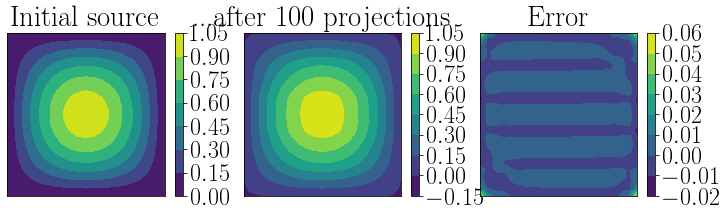

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, f in enumerate((s_init, s, err)):
    ax = axes[i]
    fig.colorbar(tricontourf(f, axes=axes[i]), ax=ax)
    ax.set_title(f.dat.name)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    if f != err:
        print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
print("Relative L2 error = {:.2f}%".format(100*l2_error[-1]))
print("Relative mass error = {:.2f}%".format(100*mass_error[-1]))

Initial source
...after 100 projections


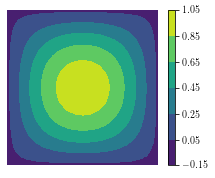

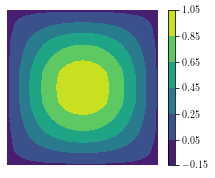

In [23]:
for f in (s_init, s):
    fig, axes = plt.subplots(figsize=(3.5, 3))
    cbar = fig.colorbar(tricontourf(f, axes=axes, levels=np.linspace(-0.15, 1.05, 7)), ax=axes)
    cbar.ax.tick_params(labelsize=10)
    axes.axis(False)
    print(f.dat.name)
    savefig("_".join(f.dat.name.split()), "plots", ["png"])

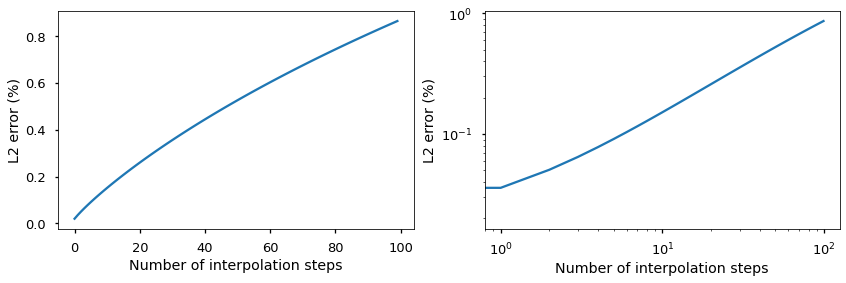

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(100*np.array(l2_error));
axes[0].set_xlabel("Number of interpolation steps")
axes[0].set_ylabel("L2 error (%)");
axes[1].loglog(100*np.array(l2_error));
axes[1].set_xlabel("Number of interpolation steps")
axes[1].set_ylabel("L2 error (%)");

Even after projecting from $\mathcal H_S$ to $\mathcal H_T$ and back again 100 times, the relative $\mathcal L_2$ error is still less than 1% and the relative mass error is zero (by construction).

Whilst the $\mathcal L_2$ error is small, it does continue to grow.

Note that the supermesh projection may be written

$$q_T = P_{ST} q_S,\qquad\text{where}\qquad P_{ST}:=M_T^{-1} M_{ST},$$

although it probably isn't worth assembling it in practice.

In [59]:
import scipy.sparse as sp

In [60]:
def get_csr_matrix(mat):
    """Extract data from PETSc Mat in CSR format."""
    indptr, indices, data = mat.getValuesCSR()
    return sp.csr_matrix((data, indices, indptr), shape=mat.getSize())

In [106]:
def plot_matrix(matrix, ax, name):
    m, n = matrix.getSize()
#     tmp = matrix.copy()
#     tmp.convert('dense')
#     ax.spy(tmp.getDenseArray())
    csr = get_csr_matrix(matrix)
    ax.spy(csr, markersize=0.2)
    ax.set_title(name)
    ax.set_xlabel(str(n))
    ax.set_ylabel(str(m))
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    ax.annotate("nnz = {:d}".format(csr.nnz), xy=(0.6*n, 0.1*m))

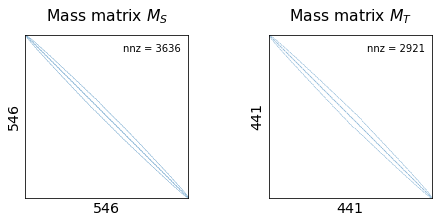

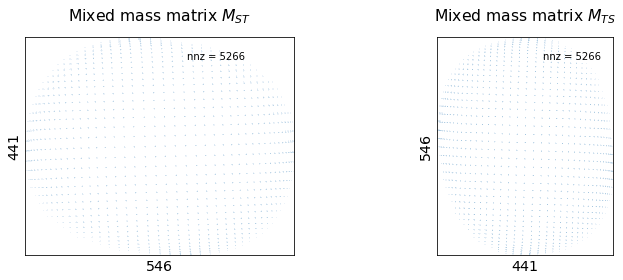

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
plot_matrix(M_s, axes[0], name='Mass matrix $M_S$')
plot_matrix(M_t, axes[1], name='Mass matrix $M_T$')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_matrix(M_st, axes[0], name='Mixed mass matrix $M_{ST}$')
plot_matrix(M_ts, axes[1], name='Mixed mass matrix $M_{TS}$')

Note that if we use a P1DG space instead of P1 then mass matrices $M_S$ and $M_T$ are tridiagonal.

In [108]:
Vs = FunctionSpace(Hs, "DG", 1)
Vt = FunctionSpace(Ht, "DG", 1)
M_st = supermesh.assemble_mixed_mass_matrix(Vs, Vt)
M_ts = supermesh.assemble_mixed_mass_matrix(Vt, Vs)
M_s = assemble(inner(TrialFunction(Vs), TestFunction(Vs))*dx).M.handle
M_t = assemble(inner(TrialFunction(Vt), TestFunction(Vt))*dx).M.handle

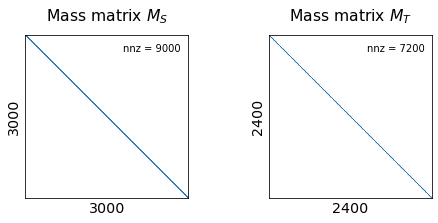

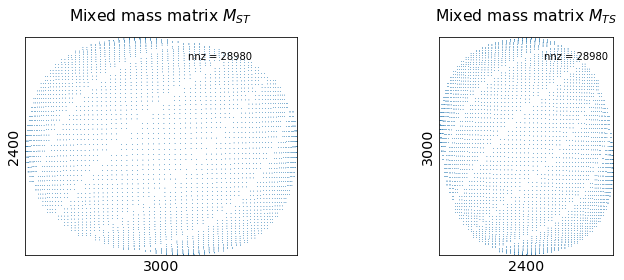

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
plot_matrix(M_s, axes[0], name='Mass matrix $M_S$')
plot_matrix(M_t, axes[1], name='Mass matrix $M_T$')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_matrix(M_st, axes[0], name='Mixed mass matrix $M_{ST}$')
plot_matrix(M_ts, axes[1], name='Mixed mass matrix $M_{TS}$')